#Import lib

In [1]:
!pip install cleverhans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 12.5 MB/s eta 0:00:00


In [2]:
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Conv2D, Input

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
import pandas as pd


import matplotlib.pyplot as plt


## LOAD CIFAR-10 DATASET

In [3]:
def ld_cifar10():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 127.5
        image -= 1.0
        return image, label

    dataset, info = tfds.load("cifar10", with_info=True, as_supervised=True)

    def augment_mirror(x):
        return tf.image.random_flip_left_right(x)

    def augment_shift(x, w=4):
        y = tf.pad(x, [[w] * 2, [w] * 2, [0] * 2], mode="REFLECT")
        return tf.image.random_crop(y, tf.shape(x))

    cifar10_train, cifar10_test = dataset["train"], dataset["test"]
    # Augmentation helps a lot in CIFAR10
    cifar10_train = cifar10_train.map(
        lambda x, y: (augment_mirror(augment_shift(x)), y)
    )
    cifar10_train = cifar10_train.map(convert_types).shuffle(10000).batch(128)
    cifar10_test = cifar10_test.map(convert_types).batch(1000)

    return EasyDict(train=cifar10_train, test=cifar10_test)

In [14]:
# Variables
nb_epochs=50
#Les budgets sont en norme infini
adv_perturbation_budget=0.5
pgd_iterations=10
pgd_step_budget=0.05

adv_train=False

data = ld_cifar10()
input_shape=(32,32,3)
num_classes=10

# Model Under Test
def Resnet_block(x, filters, size, num_comb,add=False):

    # Shortcut : si le nombre de filtres change, on l’adapte
    if x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), padding='same', use_bias=False)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x

    if (add==True):
      for i in range(0, num_comb):
          size = size + 2*i
          x = layers.Conv2D(filters, (size, size), padding='same', use_bias=False)(x)
          x = layers.BatchNormalization()(x)
          x = layers.Activation('relu')(x)
    else :
        for i in range(0, num_comb):
          x = layers.Conv2D(filters, (size, size), padding='same', use_bias=False)(x)
          x = layers.BatchNormalization()(x)
          x = layers.Activation('relu')(x)


    # Ajout du shortcut
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_resnet1(input_shape=(32,32,3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Bloc initial
    x = layers.Conv2D(8, (3,3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # --- Blocs ResNet ---
    x = Resnet_block(x, filters=8, size=3, num_comb=3)
    x = Resnet_block(x, filters=8, size=3, num_comb=3)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = Resnet_block(x, filters=16, size=3, num_comb=3)
    x = Resnet_block(x, filters=16, size=3, num_comb=3)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Classification finale
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.35)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="Simple_ResNet")
    return model

model = build_resnet1()
# Load training and test data


#model = Model(inputs, x)
model.summary()

loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Metrics to track the different accuracies.
train_loss = tf.metrics.Mean(name="train_loss")
train_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    predictions = model(x)
    loss = loss_object(y, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_acc_clean(y,predictions)

# Train model with adversarial training
for epoch in range(nb_epochs):
  # keras like pp of progress
  progress_bar_train = tf.keras.utils.Progbar(50000)
  for (x, y) in data.train:
    if adv_train:
      # Replace clean example with adversarial example for adversarial training
      x = projected_gradient_descent(model, x, adv_perturbation_budget, 0.01, 40, np.inf)
    train_step(x, y)
    progress_bar_train.add(x.shape[0], values=[("epoch",epoch),("Loss (train)", train_loss.result())])



Model: "Simple_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 32, 8) │        216 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_80       │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 32, 32, 8) │        576 │ activation_80[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_81       │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 32, 32, 8) │        576 │ activation_81[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_82       │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 32, 32, 8) │        576 │ activation_82[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_83       │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ activation_83[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
│                     │                   │            │ activation_80[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_84       │ (None, 32, 32, 8) │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 32, 32, 8) │        576 │ activation_84[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_72[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 59,714 (233.26 KB)

 Trainable params: 59,026 (230.57 KB)

 Non-trainable params: 688 (2.69 KB)

50000/50000 ━━━━━━━━━━━━━━━━━━━━ 31s 625us/step - epoch: 0.0000e+00 - Loss (train): 2.0244
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 325us/step - epoch: 1.0000 - Loss (train): 1.7575
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 320us/step - epoch: 2.0000 - Loss (train): 1.6276
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 324us/step - epoch: 3.0000 - Loss (train): 1.5358
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 320us/step - epoch: 4.0000 - Loss (train): 1.4657
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 312us/step - epoch: 5.0000 - Loss (train): 1.4095
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 314us/step - epoch: 6.0000 - Loss (train): 1.3637
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 18s 363us/step - epoch: 7.0000 - Loss (train): 1.3239
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 17s 331us/step - epoch: 8.0000 - Loss (train): 1.2898
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 318us/step - epoch: 9.0000 - Loss (train): 1.2590
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 323us/step - epoch: 10.0000 - Loss (train): 1.2316
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 16s 3

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step

--- Evaluation Results ---
test acc on clean examples (%): 79.050
test acc on FGM adversarial examples (%): 11.750
test acc on PGD adversarial examples (%): 7.230

--- Comparative Table (First 100 samples) ---
Comparative table saved to resultat_model19_adv_05_pgdstep_005.txt
Maximum perturbation:  0.5


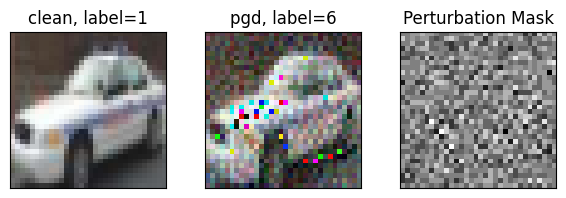

In [15]:
# Evaluate on clean and adversarial data
progress_bar_test = tf.keras.utils.Progbar(10000)

# Lists to store results for a few examples
true_labels = []
clean_preds = []
fgsm_preds = []
pgd_preds = []
clean_confidences = []
fgsm_confidences = []
pgd_confidences = []

sample_count = 0
max_samples_to_display = 100  # Display results for up to 100 samples

for x, y in data.test:
  #print(np.shape(x))
  y_pred = model(x)
  test_acc_clean(y, y_pred)

  #ATTACKS WITH FGSM
  x_fgm = fast_gradient_method(model, x, adv_perturbation_budget, np.inf)
  y_pred_fgm = model(x_fgm)
  test_acc_fgsm(y, y_pred_fgm)

  #ATTACKS WITH PGD (iterative attack)
  x_pgd = projected_gradient_descent(model, x, adv_perturbation_budget, pgd_step_budget, pgd_iterations, np.inf)
  y_pred_pgd = model(x_pgd)
  test_acc_pgd(y, y_pred_pgd)

  # Store results for display
  if sample_count < max_samples_to_display:
      true_labels.extend(tf.get_static_value(y[:max_samples_to_display-sample_count]))

      clean_pred_values = tf.get_static_value(y_pred[:max_samples_to_display-sample_count])
      clean_preds.extend(tf.get_static_value(tf.argmax(clean_pred_values, axis=1)))
      clean_confidences.extend(tf.get_static_value(tf.reduce_max(tf.nn.softmax(clean_pred_values, axis=1), axis=1)))

      fgsm_pred_values = tf.get_static_value(y_pred_fgm[:max_samples_to_display-sample_count])
      fgsm_preds.extend(tf.get_static_value(tf.argmax(fgsm_pred_values, axis=1)))
      fgsm_confidences.extend(tf.get_static_value(tf.reduce_max(tf.nn.softmax(fgsm_pred_values, axis=1), axis=1)))

      pgd_pred_values = tf.get_static_value(y_pred_pgd[:max_samples_to_display-sample_count])
      pgd_preds.extend(tf.get_static_value(tf.argmax(pgd_pred_values, axis=1)))
      pgd_confidences.extend(tf.get_static_value(tf.reduce_max(tf.nn.softmax(pgd_pred_values, axis=1), axis=1)))


      sample_count += x.shape[0]


  #Print the clean accuracy (no attack) and the adversarial accuracy (i.e., the accuracy computed on the adversarial images)
  #NB: CIFAR-10 has 10 labels, the "random guess level" is accuracy=1/10=0.1
  progress_bar_test.add(x.shape[0])

print("\n--- Evaluation Results ---")
print("test acc on clean examples (%): {:.3f}".format(test_acc_clean.result() * 100))
print("test acc on FGM adversarial examples (%): {:.3f}".format(test_acc_fgsm.result() * 100)) #Utilisation du gradient pour genere une images (un mask)
print("test acc on PGD adversarial examples (%): {:.3f}".format(test_acc_pgd.result() * 100)) #La meme mais en iterative

# Display comparative table for a few examples
import pandas as pd

results_df = pd.DataFrame({
    'True Label': true_labels,
    'Clean Prediction': clean_preds,
    'Clean Confidence': clean_confidences,
    'FGSM Prediction': fgsm_preds,
    'FGSM Confidence': fgsm_confidences,
    'PGD Prediction': pgd_preds,
    'PGD Confidence': pgd_confidences
})

print("\n--- Comparative Table (First {} samples) ---".format(max_samples_to_display))
#display(results_df) # Commented out the display

# Save the table to a text file
adv_budget_str = str(adv_perturbation_budget).replace('.', '')
pgd_step_str = str(pgd_step_budget).replace('.', '')
filename = f'resultat_model19_adv_{adv_budget_str}_pgdstep_{pgd_step_str}.txt'

with open(filename, 'w') as f:
    f.write("--- Evaluation Results ---\n")
    f.write("test acc on clean examples (%): {:.3f}\n".format(test_acc_clean.result() * 100))
    f.write("test acc on FGM adversarial examples (%): {:.3f}\n".format(test_acc_fgsm.result() * 100))
    f.write("test acc on PGD adversarial examples (%): {:.3f}\n".format(test_acc_pgd.result() * 100))
    f.write("\n--- Comparative Table (First {} samples) ---\n".format(max_samples_to_display))
    results_df.to_csv(f, sep='\t', index=False)

print(f"Comparative table saved to {filename}")


#SHOW THE ATTACK for a random sample
rand_sample_id=np.random.randint(np.shape(x)[0])

#We normalized our images into [0;1]. We make the inverse process to go into [0,255]
#NB: For the attacked images, the max perturbation is +/-0.05, so the images will be in [-0.05,1.05]
x_display = tf.cast(127.5*(x[rand_sample_id,:,:,:]+1.0),tf.uint8)
x_pgd_display = tf.cast(121.4*(x_pgd[rand_sample_id,:,:,:]+1.05),tf.uint8)
perturbation = x_pgd[rand_sample_id,:,:,:] - x[rand_sample_id,:,:,:]
print('Maximum perturbation: ',np.amax(perturbation))

#Display
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), subplot_kw={'xticks': [], 'yticks': []})
axs.flat[0].imshow(tf.cast(x_display,tf.uint8))
axs.flat[0].set_title(str('clean, label=')+str(tf.get_static_value(y[rand_sample_id])))
axs.flat[1].imshow(tf.cast(x_pgd_display,tf.uint8))
axs.flat[1].set_title(str('pgd, label=')+str(np.argmax(tf.get_static_value(y_pred_pgd[rand_sample_id]))))
axs.flat[2].imshow(perturbation[:,:,0], cmap='gray')
axs.flat[2].set_title('Perturbation Mask')
plt.tight_layout()
plt.show()